# Main Imports

In [4]:
import sys
import re, numpy as np, pandas as pd
from pprint import pprint
import seaborn as sns

import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from matplotlib import rcParams

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Take a peak at the stop words and decide if you want to add to it.
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

## Note about Code:

Code modified in parts from https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

# Load Data

In [5]:
#Here, we are reading in a csv file. See 'nb1_Amazon_NMF_nb1.ipynb' to see the JSON method.

amazon_ss = pd.read_csv('/<Directory>/<User>/amazon_ss.csv') # Subsample of main dataframe from nb1t
amazon_ss['reviewText'] = amazon_ss['reviewText'].astype(str) #Make type 'string' for len count

## Create 'reviewText_len' column

In [6]:
#Count the number of words in the 'reviewText' column.

count = amazon_ss['reviewText'].str.split().str.len()
pd.Series(count)
amazon_ss['reviewText_len']=count
amazon_ss

,index,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,reviewText_len
0,1655283,4,NaN,True,"12 2, 2010",AD7G6HA68XNTA,B003O5FOWC,NaN,D. Brewer,works great got rid of the wires from the main...,Nice to Have Surround Sound Without The Wires,1291248000,NaN,24
1,3383009,5,NaN,True,"04 21, 2016",A1LHHZCRANBW4W,B00CPTSRIQ,NaN,Robert Allocca,cheaper than buying from magellan or anywhere ...,OEM,1461196800,NaN,12
2,4530887,4,NaN,True,"04 2, 2015",A3QEVT94QTD717,B00MBWIL0G,"{'Color:': ' Black', 'Package Type:': ' Standa...",Dave,i loved these headphones and for the price the...,A serious Bose competitor at a fraction of the...,1427932800,NaN,81
3,6325420,4,NaN,True,"07 26, 2013",A3FPHIHUNF2AZ9,B005EG4YJ8,NaN,Lisa J. Giovino,it is totally awesome i love it it was good ...,CAMERA KIT,1374796800,NaN,31
4,2772063,5,NaN,True,"05 16, 2017",A2AZAM4V1KX9DS,B008NCD06I,"{'Color:': ' Audio', 'Length:': ' 3 Feet'}",Billy D,nice tight fitting connections no sound or fee...,Nice,1494892800,NaN,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67391,5537514,1,NaN,True,"09 30, 2016",A32S60W4IZN3T7,B014R8JO2U,"{'Capacity:': ' 8GB Kit (2 x 4GB)', 'Style:': ...",Steve A.,i ordered the 8 gb kit 2x4gb this memory does...,I ordered the 8 GB kit (2x4GB). This memory ...,1475193600,NaN,54
67392,4866716,4,NaN,True,"08 30, 2015",A2C6DOEV3JWJO4,B00QTH9X9W,NaN,davidst95,went on great bubbles were easy to remove th...,Great Glass Cover at a Great Price,1440892800,['https://images-na.ssl-images-amazon.com/imag...,27
67393,1155149,1,NaN,True,"10 20, 2013",A2GE4332RMDZ32,B001DEYVXO,{'Style:': ' USB TV Tuner'},K. W. Rudd,like another reviewer i purchased this unit to...,Not a good fit for Linux/MythTV - Possible def...,1382227200,NaN,199
67394,5415545,4,NaN,True,"07 11, 2013",A1FCZDERYJ814U,B011WBI4S0,{'Color:': ' Plane Black'},Robert P.,very good mouse for the price ive used logitec...,Like it.,1373500800,NaN,38


In [7]:
#Take a look at the longest and shortest reviews.

amazon_ss.sort_values('reviewText_len')

,index,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,reviewText_len
50393,4545066,5,NaN,True,"04 9, 2015",A2Y7PENA4LS9YA,B00MIPC5HG,{'Color:': ' Black'},Richard Townsend,great,Five Stars,1428537600,NaN,1
29936,6145032,5,NaN,True,"09 5, 2017",A1AL6YKL5GQ68R,B000B9PXNE,NaN,Juan Camilo Castillo,good,Five Stars,1504569600,NaN,1
49045,4661006,5,NaN,True,"04 23, 2018",A1K8CSVXQUE6HG,B00NMTXYN6,{'Color:': ' Purple'},Doyle s.,a,Five Stars,1524441600,NaN,1
56953,930553,4,NaN,True,"01 16, 2018",A39GMDLDJKR3FS,B000XMM1FW,NaN,JB McCollum,works,Four Stars,1516060800,NaN,1
53325,4564023,5,NaN,True,"10 6, 2016",AGVVYYEQOORAV,B00MQLB1N6,NaN,Phyllis,nice,Nice.,1475712000,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42186,4287247,4,11,False,"12 2, 2014",A1TO6BO58N6PHJ,B00K962E7C,{'Color:': ' Gray'},AJC,hey average joe consumer here again with anoth...,"Good, but picture quality and sensor issues ho...",1417478400,NaN,2351
38269,3196115,2,"7,739",False,"04 16, 2013",A1N3HHWQH225GB,B00BGO0Q9O,"{'Size:': ' Two wristbands included, Large (6....",D. Graves,the flex is fairly good if you understand its...,Why does this now have over 4 THOUSAND negativ...,1366070400,NaN,2395
65434,4325115,4,23,False,"05 23, 2015",A2FFMMPUA5KXI8,B00KIWWUFI,NaN,Eric,update 112016 still using this bad boy its awe...,"Best Android tablet, sadly...",1432339200,['https://images-na.ssl-images-amazon.com/imag...,2529
30704,74726,4,9,False,"02 23, 2008",A3K6GH5N1LDKVF,B000062VUQ,{'Size:': ' 3-piece'},Tari,in this review an in depth comparison of klips...,Tough choice,1203724800,NaN,3621


In [8]:
#'''
#This review can also be found in its native habitat at https://www.amazon.com/gp/customer-reviews/R1ZXVS3NSR1JK1/ref=cm_cr_arp_d_viewpnt?ie=UTF8&ASIN=B00Y0LXDZE#R1ZXVS3NSR1JK1
#'''

amazon_ss.loc[38589]['reviewText']

'    nbspupdate 1152018 i have increased my rating from 1 star to 4 stars and likely would have given the camera 5 stars if the problems were not present when the camera was purchased or if the problems were fixed within the first month of ownership  while i recognize that not all problems are easy to fix the problems mentioned in the review below are finally fixed other than occasional stuttering in recorded video and requiring internet explorer with firmware version 660b which was released on or around 12252017  a week ago trivision also corrected a problem with their servers that permit remote access to cameras  prior to that fix i could access neither the nc250pw nor the nc350pw cameras remotely and at most 5 of 23 cameras that i have defined in camera live would display if i used a 2013 version of the program and zero would display if i used the 2014 or newer version of the program  after the servers were fixed all cameras were accessible remotely again the nc250pw and nc350pw cam

[(0.0, 5000.0), (0.0, 100.0)]

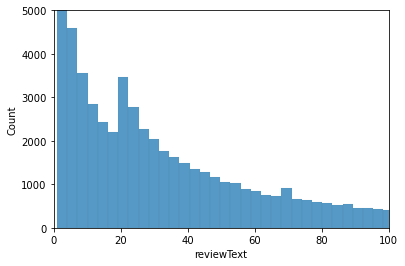

In [9]:
#Plot up the count of reviewText docs by length.

count_sorted=count.sort_values()
count_plot = sns.histplot(x=count_sorted)
count_plot.set(ylim=(0, 5000),xlim=(0,100))

#Note the curve shapre around reviewText=20.  Not sure what is going on there.

# Data Prep

In [10]:
#Clean up special charecters and quotes.

def review_to_words(reviews):
    for review in reviews:
        review = re.sub('\S*@\S*\s?', '', review)  # remove emails
        review = re.sub('\s+', ' ', review)  # remove newline chars
        review = re.sub("\'", "", review)  # remove single quotes
        review = gensim.utils.simple_preprocess(str(review), deacc=True) 
        yield(review)

In [11]:
#Quick scan of the dtypes for good measure.  I find it good to just check this once in a while
# so that I don't burn time tracking down dtype errors.

amazon_ss.dtypes

index              int64
overall            int64
vote              object
verified            bool
reviewTime        object
reviewerID        object
asin              object
style             object
reviewerName      object
reviewText        object
summary           object
unixReviewTime     int64
image             object
reviewText_len     int64
dtype: object

In [12]:
#Convert to list for Gensim
data = amazon_ss.reviewText.values.tolist()
data_words = list(review_to_words(data))

## Gensim

### Bi-, Tri-grams, and Lemmatization

In [13]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold = fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Remove Stopwords, Form Bigrams, Trigrams and Lemmatization

## Additional stop-words

In [14]:
#Additional stop-words added for each project.

new_stop = ['good', 'great', 'work', 'get', 'well', 'give', 'use', 'go', 'try', 'item', 'excellent', 'happy', 'product', 'buy', 'say','think','make','hold','take','see','know','however','tell','need','line']

for word in new_stop:
    stop_words.append(word)

In [15]:
#Processing function.  

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for review in texts:
        doc = nlp(" ".join(review)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

# Build the Topic Model using LDA (Latent Dirichlet Allocation)

This is the most time consuming step.  4 topics = 30 minutes, 8 topics = 50 minutes.

In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, #Change the number of topics here.  4-12 is a good range to start with.
                                           random_state=42,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [17]:
#Print to check results

pprint(lda_model.print_topics())

[(0,
  '0.029*"time" + 0.027*"camera" + 0.016*"thing" + 0.016*"tv" + 0.014*"set" + '
  '0.012*"fine" + 0.011*"connect" + 0.011*"picture" + 0.010*"mount" + '
  '0.010*"video"'),
 (1,
  '0.033*"quality" + 0.033*"sound" + 0.030*"look" + 0.027*"speaker" + '
  '0.022*"lens" + 0.018*"screen" + 0.016*"really" + 0.013*"way" + 0.012*"size" '
  '+ 0.012*"high"'),
 (2,
  '0.029*"case" + 0.023*"fit" + 0.019*"laptop" + 0.018*"tablet" + '
  '0.016*"drive" + 0.015*"old" + 0.015*"new" + 0.013*"back" + 0.013*"fast" + '
  '0.012*"perfect"'),
 (3,
  '0.020*"cable" + 0.015*"unit" + 0.015*"battery" + 0.015*"device" + '
  '0.013*"problem" + 0.013*"plug" + 0.011*"power" + 0.010*"long" + '
  '0.010*"recommend" + 0.010*"day"'),
 (4,
  '0.048*"price" + 0.032*"love" + 0.024*"light" + 0.019*"phone" + '
  '0.019*"keyboard" + 0.018*"bit" + 0.018*"headphone" + 0.015*"button" + '
  '0.014*"control" + 0.014*"little"')]


## Topic Extraction

In [18]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Percentage Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.8470,"quality, sound, look, speaker, lens, screen, r...","[rid, wire, main, surround, sound, unit, back,..."
1,1,2.0,0.5227,"case, fit, laptop, tablet, drive, old, new, ba...","[cheap, buying, magellan, anywhere, else, knoc..."
2,2,4.0,0.9102,"price, love, light, phone, keyboard, bit, head...","[love, headphone, price, bit, bose_qc, control..."
3,3,0.0,0.6500,"time, camera, thing, tv, set, fine, connect, p...","[totally, awesome, love, thing, remote, guess,..."
4,4,1.0,0.6889,"quality, sound, look, speaker, lens, screen, r...","[tight, fitting, connection, sound, feedback, ..."
5,5,0.0,0.5309,"time, camera, thing, tv, set, fine, connect, p...","[love, plug, flashdrive, time, working, inch, ..."
6,6,3.0,0.8110,"cable, unit, battery, device, problem, plug, p...","[siren, hook, almond, controller, month, siren..."
7,7,1.0,0.4400,"quality, sound, look, speaker, lens, screen, r...","[perfect, digital, frame, order]"
8,8,3.0,0.8440,"cable, unit, battery, device, problem, plug, p...","[device, brainer, simple, concept, mine, break..."
9,9,1.0,0.7460,"quality, sound, look, speaker, lens, screen, r...","[guy, really, look, futuristic, boss, put, bon..."


## Get Representative Text

In [19]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9428,"time, camera, thing, tv, set, fine, connect, picture, mount, video","[smart, tv, portion, never, netflix, load, clear, picture, cost, fall, vizio, app, feature]"
1,1.0,0.9315,"quality, sound, look, speaker, lens, screen, really, way, size, high","[speaker, sound, custom, fit, tweeter, front, door, handa, civic, rear, deck, honda, crossover, ..."
2,2.0,0.9283,"case, fit, laptop, tablet, drive, old, new, back, fast, perfect","[little, thingy, fit, pocket, key_chain, gb, gb, drive, fit, problem, pocket]"
3,3.0,0.9326,"cable, unit, battery, device, problem, plug, power, long, recommend, day","[luck, usbserial, cable, garmin, etrex, able, help, save, money, vista, computer]"
4,4.0,0.9102,"price, love, light, phone, keyboard, bit, headphone, button, control, little","[love, headphone, price, bit, bose_qc, control, operate, headphone, wear, glove, complaint, bulk..."


In [20]:
# Plots and Visualizations

# Document Word Count Histogram

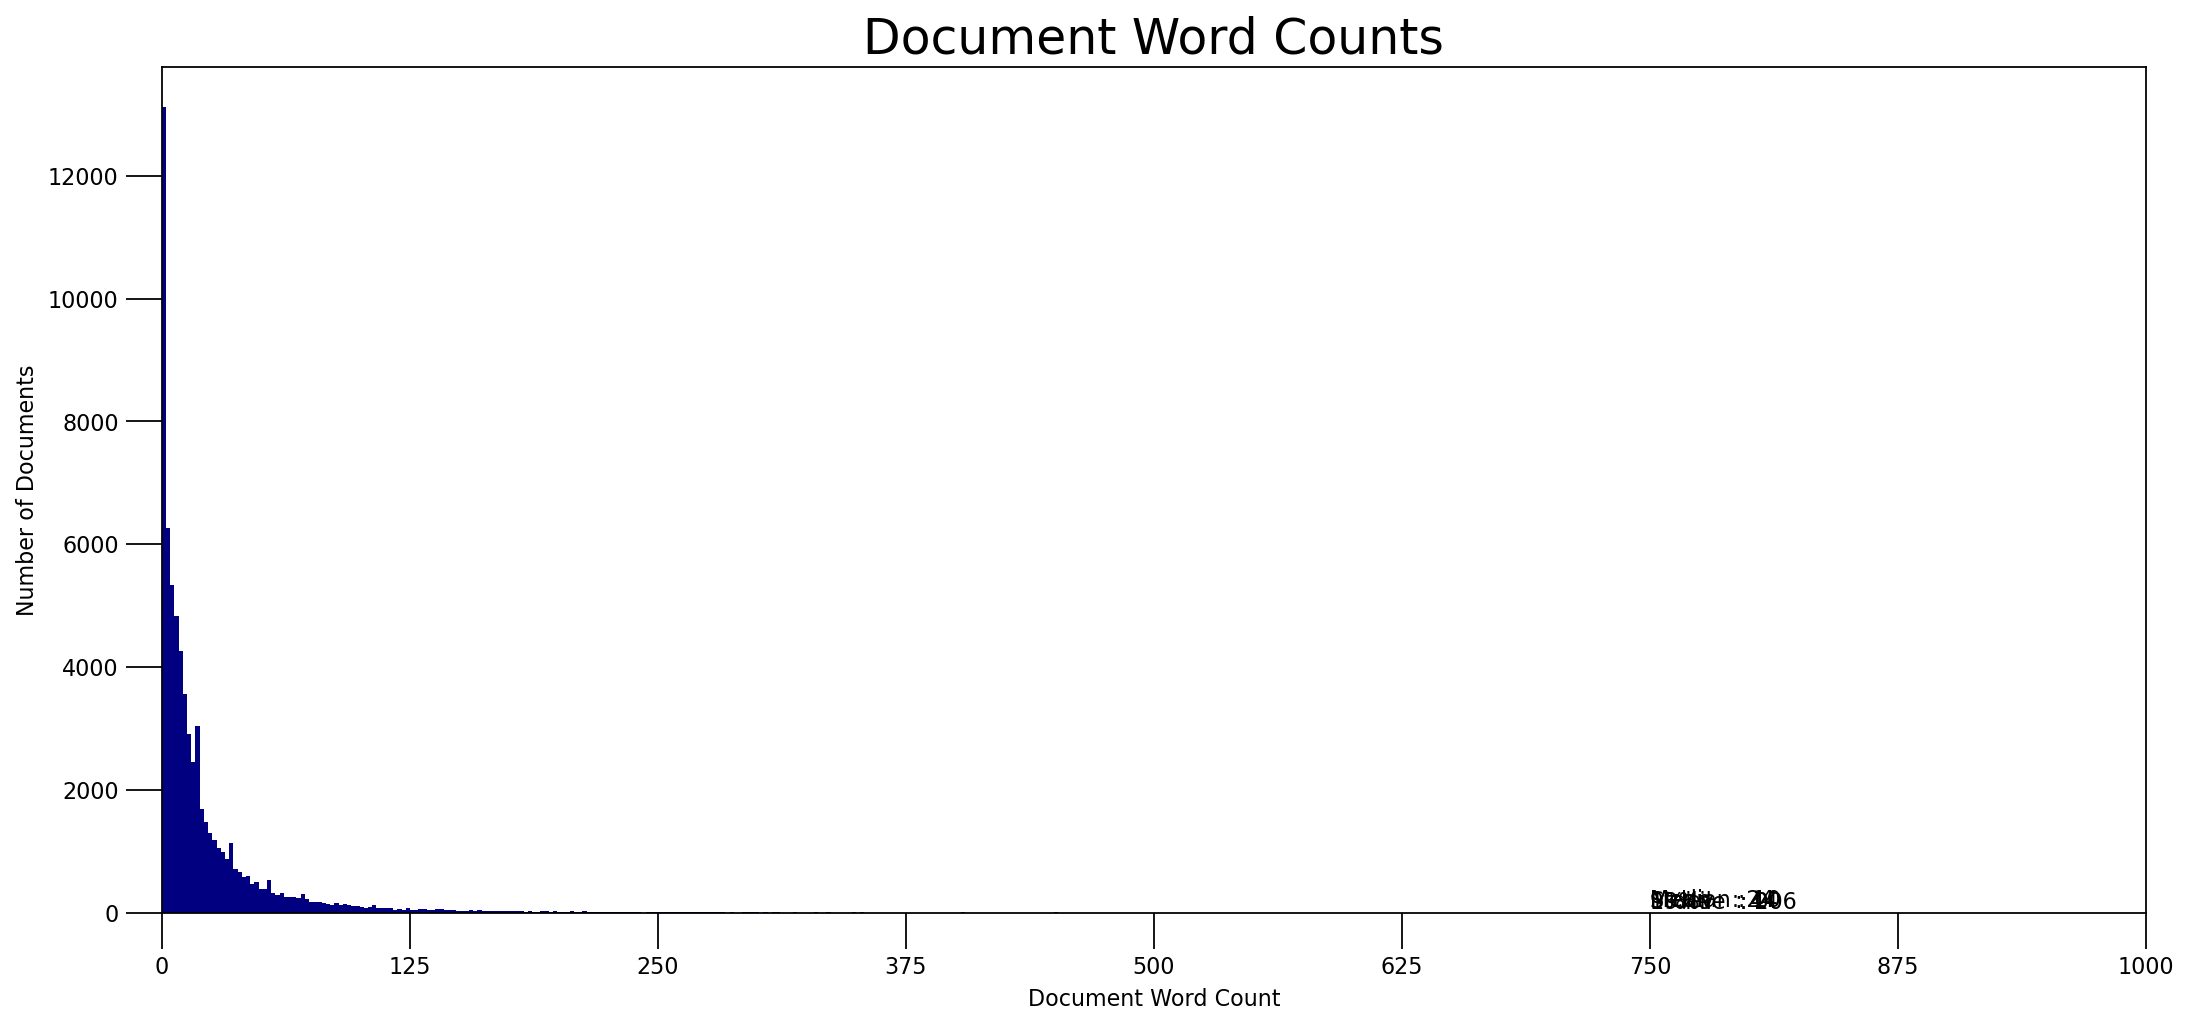

In [21]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy') #Plot inputs here
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Document Word Counts', fontdict=dict(size=22))
plt.show()

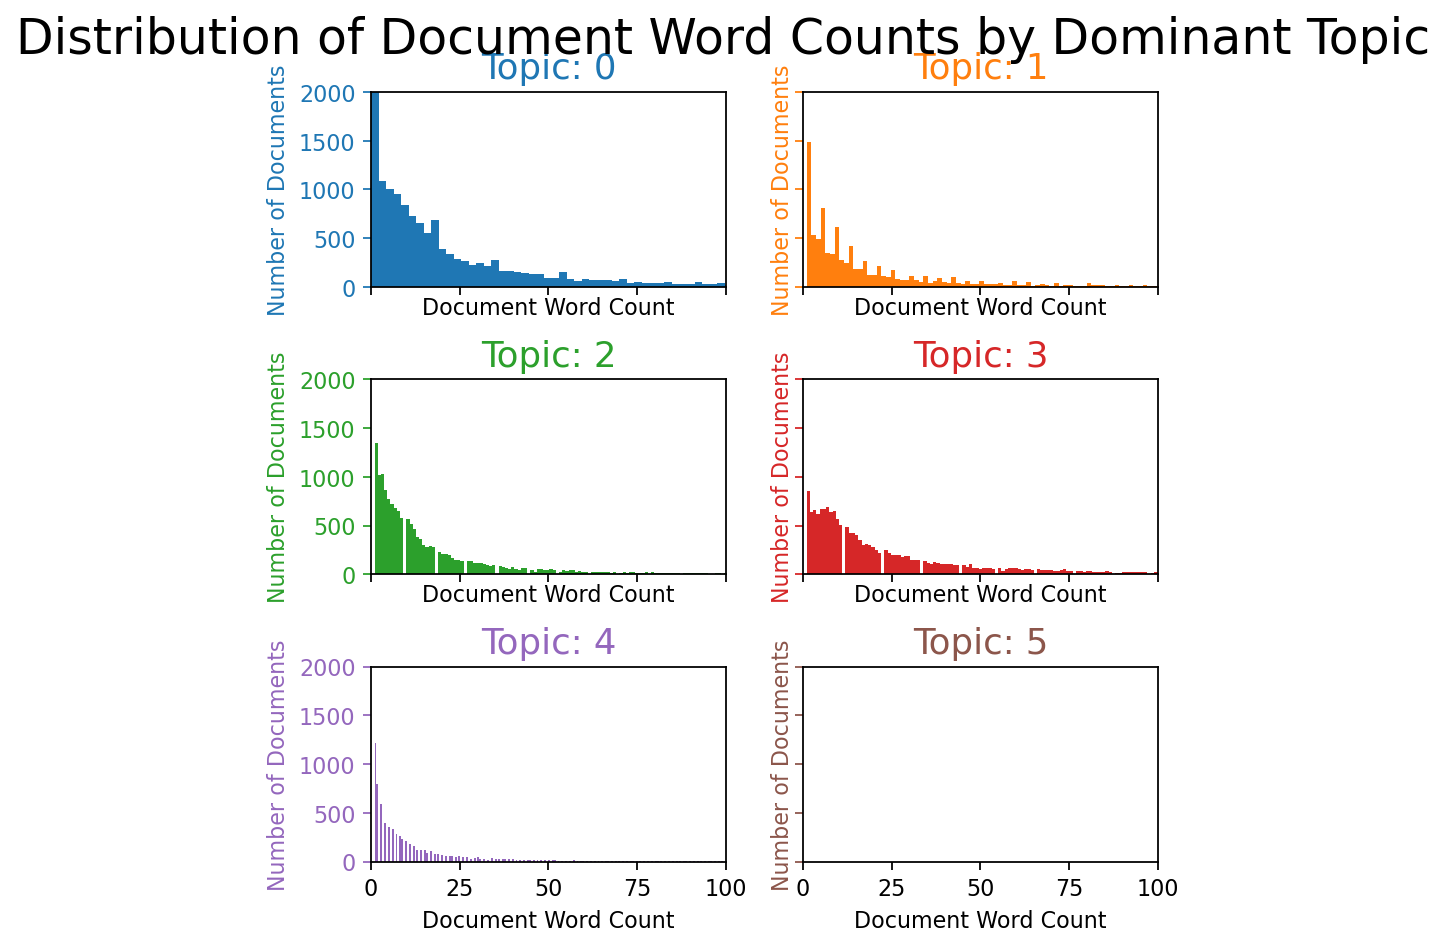

In [22]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,2,figsize=(6,6), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i]) #Plot input
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    
    ax.set(xlim=(0, 100), xlabel='Document Word Count')
    ax.set(ylim=(0,2000))
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,100,5))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

#fig.savefig("doc_word_count_plot.pdf", format="pdf", dpi=300)
#Save figure when desired.

In [23]:
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.8470,"quality, sound, look, speaker, lens, screen, really, way, size, high","[rid, wire, main, surround, sound, unit, back, speaker, room, look, neat]"
1,1,2.0,0.5227,"case, fit, laptop, tablet, drive, old, new, back, fast, perfect","[cheap, buying, magellan, anywhere, else, knockoff]"
2,2,4.0,0.9102,"price, love, light, phone, keyboard, bit, headphone, button, control, little","[love, headphone, price, bit, bose_qc, control, operate, headphone, wear, glove, complaint, bulk..."
3,3,0.0,0.6500,"time, camera, thing, tv, set, fine, connect, picture, mount, video","[totally, awesome, love, thing, remote, guess, break]"
4,4,1.0,0.6889,"quality, sound, look, speaker, lens, screen, really, way, size, high","[tight, fitting, connection, sound, feedback, wire, solid, price]"
5,5,0.0,0.5309,"time, camera, thing, tv, set, fine, connect, picture, mount, video","[love, plug, flashdrive, time, working, inch, cord, gene, fom]"
6,6,3.0,0.8110,"cable, unit, battery, device, problem, plug, power, long, recommend, day","[siren, hook, almond, controller, month, siren, loud, enough, battery, unit, bulky, battery, sev..."
7,7,1.0,0.4400,"quality, sound, look, speaker, lens, screen, really, way, size, high","[perfect, digital, frame, order]"
8,8,3.0,0.8440,"cable, unit, battery, device, problem, plug, power, long, recommend, day","[device, brainer, simple, concept, mine, break, week, plug, cool, blue, light, charge, device, p..."
9,9,1.0,0.7460,"quality, sound, look, speaker, lens, screen, really, way, size, high","[guy, really, look, futuristic, boss, put, bond, movie, really, price, size, top]"


# Word Clouds

In [24]:
df_dominant_topic_sub

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text


IndexError: list index out of range

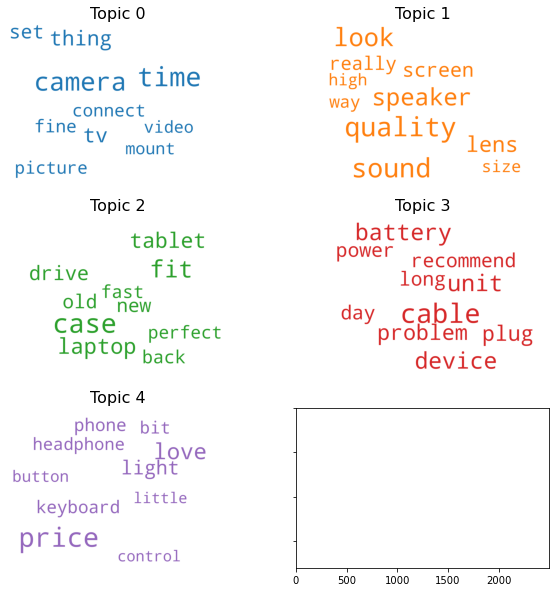

In [25]:
#Wordcloud of Top N words in each topic

#Same text as from notebook 1:
#The wordcloud isn't a super helpful quantitative device, but it does
# offer us some idea of what is going on with the frequencies of different
# words. It helped me see some words pairings I might have missed from just
# a dataframe or list ouput, but use with caution.

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Topic Word Counts

In [ ]:
from collections import Counter

topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count') #This is the actual line for he plot
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.040); ax.set_ylim(0, 12000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

# Sentence Topic Coloring

In [ ]:
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13): #Note: Pay attention to the 'start' and 'end'.  Some of the sentences you'll get won't be helpful.
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160) #Plot line.
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  #To move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()  

# Most Discussed Topics in Docs

In [ ]:
#Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

#Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

In [ ]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 20000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=6))

plt.show()

# pyLDAVis

In [ ]:
import pyLDAvis.gensim


#This figure will show you how related the topics are.  The more they overlap, the more
# similar they are.  Aim for maximum sepeartebility when possible, but use your human
# brain and domain knowledge to decide when it's truly appropriate.

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis